In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from collections import OrderedDict
from numpy.random import default_rng
from tqdm.notebook import tqdm

from golds.options_math import andersen, black_scholes
from golds.contracts import Option, OptionStyle, Stock
from train_parallel import get_save_dir
from compute_delta_hedging_results_parallel import NUM_SHARES_UNDERLYING, get_hyperparams_dict_from_save_dir

2021-05-19 15:07:17 DEBUG    backend module://ipykernel.pylab.backend_inline version unknown


size of hyperparam grid: 512


In [2]:
pd.set_option('display.max_rows', 500)

## Determine which hyperparam values lead to most variation in holdings (across runs)

In [3]:
hyperparam_dirs = list(dirpath for dirpath, dirnames, filenames in os.walk('checkpoints/euro_hedging_asymmetric_reward_clipping') if filenames)

In [4]:
len(hyperparam_dirs)

512

In [5]:
std_series = []
goodness_series = []
index_dicts = []

for dirpath in tqdm(hyperparam_dirs):
    components = dirpath.split('/')
    hyperparams_dict = OrderedDict()
    for component in components:
        if '=' in component:
            key, val = component.split('=')
            hyperparams_dict[key] = float(val)
            
    try:
        results_fpath = os.path.join(dirpath, "delta_hedging_analysis.h5")
        stock_holdings_df = pd.read_hdf(results_fpath, key="stock_holdings")
        delta_df = pd.read_hdf(results_fpath, key="delta")
    except FileNotFoundError:
        logging.warning(f"No delta_hedging_analysis.h5 found for hyperparams={hyperparams_dict} -- failed to compute?")
        continue
        
    stock_holdings_std = stock_holdings_df.std(axis=1)
    # stock_holdings_std will be of length 252 (for each day, it tells us the stdev of holdings across the 100 OOS runs)
    assert stock_holdings_std.index.equals(stock_holdings_df.index)
    
    optimal_hedge_df = -NUM_SHARES_UNDERLYING*delta_df
    goodness = np.sqrt(((optimal_hedge_df-stock_holdings_df)**2).sum().sum())
    
    goodness_series.append(goodness)
    std_series.append(stock_holdings_std)
    index_dicts.append(hyperparams_dict)
    
hyperparams_index = pd.MultiIndex.from_frame(pd.DataFrame.from_records(index_dicts))

holdings_std_df = pd.concat(std_series, axis='columns', ignore_index=True).transpose()
holdings_std_df.index = hyperparams_index

goodness_series = pd.Series(goodness_series, index=hyperparams_index)

  0%|          | 0/512 [00:00<?, ?it/s]

2021-05-19 15:07:20 INFO     NumExpr defaulting to 8 threads.


In [6]:
goodness_series.sort_values()

gamma  gae_lambda  ent_coef  vf_coef  max_grad_norm
0.881  0.783       0.236     0.5      0.5              3.179284e+04
0.936  0.990       0.236     0.5      0.5              3.359075e+04
0.990  0.949       0.257     0.5      0.5              5.660008e+04
       0.824       0.193     0.5      0.5              5.794445e+04
0.827  0.824       0.150     0.5      0.5              6.038669e+04
                                                           ...     
0.881  0.783       0.214     0.5      0.5              2.037150e+06
0.990  0.824       0.214     0.5      0.5              2.086998e+06
       0.866       0.236     0.5      0.5              2.121203e+06
       0.741       0.150     0.5      0.5              2.260182e+06
       0.990       0.279     0.5      0.5              2.280165e+06
Length: 512, dtype: float64

In [7]:
holdings_std_df

0          1    \
gamma gae_lambda ent_coef vf_coef max_grad_norm                         
0.990 0.866      0.257    0.5     0.5             0.000000   0.000000   
                 0.279    0.5     0.5             0.000000   0.000000   
                 0.171    0.5     0.5             0.000000   0.000000   
                 0.300    0.5     0.5            44.326013  55.651038   
                 0.236    0.5     0.5             0.000000   0.000000   
...                                                    ...        ...   
0.909 0.783      0.300    0.5     0.5            52.569388  67.658605   
                 0.236    0.5     0.5            43.644806  62.394298   
                 0.193    0.5     0.5            15.862490  25.332000   
                 0.214    0.5     0.5            41.458719  65.306070   
                 0.150    0.5     0.5            24.765984  36.935011   

                                                       2          3    \
gamma gae_lambda ent_coef vf_coef max_grad_norm                         
0.990 0.866      0.257    0.5     0.5             0.000000   0.000000   
                 0.279    0.5     0.5             0.000000   0.000000   
                 0.171    0.5     0.5             0.000000   0.000000   
                 0.300    0.5     0.5            74.550475  82.046737   
                 0.236    0.5     0.5             0.000000   0.000000   
...                                                    ...        ...   
0.909 0.783      0.300    0.5     0.5            78.226154  95.012864   
                 0.236    0.5     0.5            69.420441  86.290079   
                 0.193    0.5     0.5            35.928993  49.106670   
                 0.214    0.5     0.5            82.390803  93.764896   
                 0.150    0.5     0.5            56.999467  70.043763   

                                                        4           5    \
gamma gae_lambda ent_coef vf_coef max_grad_norm                           
0.990 0.866      0.257    0.5     0.5              0.000000    0.000000   
                 0.279    0.5     0.5              0.000000    0.000000   
                 0.171    0.5     0.5              0.000000    0.000000   
                 0.300    0.5     0.5             84.740042  102.743527   
                 0.236    0.5     0.5              0.000000    0.000000   
...                                                     ...         ...   
0.909 0.783      0.300    0.5     0.5            117.252148  133.625021   
                 0.236    0.5     0.5            104.436272  119.204864   
                 0.193    0.5     0.5             55.564209   65.715718   
                 0.214    0.5     0.5            104.729047  116.719796   
                 0.150    0.5     0.5             80.093920   88.627307   

                                                        6           7    \
gamma gae_lambda ent_coef vf_coef max_grad_norm                           
0.990 0.866      0.257    0.5     0.5              0.000000    0.000000   
                 0.279    0.5     0.5              0.000000    0.000000   
                 0.171    0.5     0.5              0.000000    0.000000   
                 0.300    0.5     0.5            118.773392  126.876182   
                 0.236    0.5     0.5              0.000000    0.000000   
...                                                     ...         ...   
0.909 0.783      0.300    0.5     0.5            143.471982  160.334832   
                 0.236    0.5     0.5            122.915368  134.507984   
                 0.193    0.5     0.5             81.060692   91.793512   
                 0.214    0.5     0.5            131.619215  144.550623   
                 0.150    0.5     0.5            102.485974  116.716212   

                                                        8           9    ...  \
gamma gae_lambda ent_coef vf_coef max_grad_norm                          ...   
0.990 0.866      0.257    0.5     0.5      

In [8]:
(holdings_std_df[0] == 0).sum()

42

In [9]:
df = holdings_std_df.mean(axis='columns').reset_index().sort_values([0])

In [10]:
df

,gamma,gae_lambda,ent_coef,vf_coef,max_grad_norm,0
0,0.990,0.866,0.257,0.5,0.5,0.000000
26,0.990,0.700,0.171,0.5,0.5,0.000000
106,0.963,0.741,0.171,0.5,0.5,0.000000
75,0.963,0.907,0.300,0.5,0.5,0.000000
33,0.990,0.990,0.279,0.5,0.5,0.000000
...,...,...,...,...,...,...
132,0.800,0.866,0.236,0.5,0.5,1481.590510
462,0.909,0.907,0.214,0.5,0.5,1497.562786
226,0.881,0.990,0.171,0.5,0.5,1516.908992
98,0.963,0.990,0.171,0.5,0.5,1590.090368


In [11]:
N_COMPARE = 10
(df.tail(N_COMPARE).reset_index(drop=True)-df.head(N_COMPARE).reset_index(drop=True)).mean(axis='index')

gamma              -0.108600
gae_lambda          0.045700
ent_coef           -0.008600
vf_coef             0.000000
max_grad_norm       0.000000
0                1481.823836
dtype: float64

In [12]:
df.tail(30)

,gamma,gae_lambda,ent_coef,vf_coef,max_grad_norm,0
299,0.827,0.741,0.300,0.5,0.5,1227.235152
177,0.800,0.949,0.279,0.5,0.5,1245.464994
125,0.963,0.783,0.193,0.5,0.5,1248.967586
217,0.881,0.700,0.279,0.5,0.5,1251.030326
430,0.854,0.741,0.214,0.5,0.5,1253.107451
289,0.827,0.990,0.279,0.5,0.5,1261.164009
184,0.800,0.783,0.257,0.5,0.5,1275.111622
323,0.936,0.866,0.300,0.5,0.5,1282.265987
159,0.800,0.700,0.150,0.5,0.5,1283.076208
158,0.800,0.700,0.214,0.5,0.5,1288.251912


In [ ]:
df.groupby('gamma')[0].mean()

In [ ]:
df.loc[228]

## Find Good Hyperparams Setting

In [13]:
def row_to_hyperparams_dict(row: pd.Series):
    hyperparams_dict = OrderedDict()
    
    for col in row.keys():
        if isinstance(col, str):
            hyperparams_dict[col] = row[col]
            
    return hyperparams_dict

In [14]:
def run_is_good(stock_holdings_for_run: pd.Series) -> bool:
    MAX_HOLDINGS = 5000
    
    return (
        (stock_holdings_for_run.abs() <= MAX_HOLDINGS).all() and
        (stock_holdings_for_run <= 0).all()
    )

In [16]:
records = []

for i in tqdm(reversed(df.index), total=len(df)):
    row = df.loc[i]
    
    hyperparams_dict = row_to_hyperparams_dict(row)
    save_dir = get_save_dir('checkpoints/euro_hedging_reward_clipping', hyperparams_dict)
    try:
        with pd.HDFStore(os.path.join(save_dir, "delta_hedging_analysis.h5"), 'r') as store:
            delta, stock_holdings, stock_prices = store['delta'], store['stock_holdings'], store['stock_prices']
    except OSError:
        continue

    min_max_abs_holdings = stock_holdings.abs().max(axis='index').min()
    mean_stdev = stock_holdings.std(axis='columns').mean()
    pct_negative = (stock_holdings <= 0).all(axis='index').sum() / len(stock_holdings.columns)
    good_runs = [
        run_is_good(stock_holdings[col]) for col in stock_holdings.columns
    ]
    
    record = {
        'save_dir': save_dir,
        'min_max_abs_holdings': min_max_abs_holdings,
        'mean_stdev': mean_stdev,
        'pct_negative': pct_negative,
        'pct_good_runs': sum(good_runs)/len(good_runs)
    }
    
    records.append(record)
    
good_holdings_df = pd.DataFrame(records)

  0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
good_holdings_df.sort_values(
    ['pct_good_runs', 'mean_stdev'],
    ascending=[False, False],
    # ['mean_stdev', 'pct_good_runs', 'pct_negative', 'min_max_abs_holdings'],
    # ascending=[False, False, False, True],
    inplace=True
)

In [ ]:
good_holdings_df[good_holdings_df['mean_stdev'] > 0]

In [ ]:
to_plot = good_holdings_df[good_holdings_df['mean_stdev'] > 0].copy()

In [ ]:
good_holdings_df['mean_stdev'].max()

## Plot Delta Hedging Results

In [17]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

In [158]:
# hyperparams_dict = OrderedDict(zip(goodness_series.index.names, goodness_series.sort_values().index[0]))
# save_dir = to_plot['save_dir'].values[3]
# save_dir = '/home/ashwin/src/RL-Finance/checkpoints/euro_hedging_asymmetric_reward_clipping/gamma=0.800/gae_lambda=0.741/ent_coef=0.214/vf_coef=0.500/max_grad_norm=0.500'
# save_dir = '/home/ashwin/src/RL-Finance/checkpoints/euro_hedging_asymmetric_reward_clipping/gamma=0.800/gae_lambda=0.700/ent_coef=0.150/vf_coef=0.500/max_grad_norm=0.500'
# save_dir = '/home/ashwin/src/RL-Finance/checkpoints/euro_hedging_asymmetric_reward_clipping/gamma=0.800/gae_lambda=0.700/ent_coef=0.150/vf_coef=0.500/max_grad_norm=0.500'
# save_dir = '/home/ashwin/src/RL-Finance/checkpoints/american_hedging/gamma=0.881/gae_lambda=0.949/ent_coef=0.257/vf_coef=0.500/max_grad_norm=0.500'
# save_dir = '/home/ashwin/src/RL-Finance/checkpoints/american_hedging/gamma=0.881/gae_lambda=0.741/ent_coef=0.300/vf_coef=0.500/max_grad_norm=0.500'
save_dir = '/home/ashwin/src/RL-Finance/checkpoints/american_hedging/gamma=0.827/gae_lambda=0.949/ent_coef=0.193/vf_coef=0.500/max_grad_norm=0.500'
hyperparams_dict = get_hyperparams_dict_from_save_dir(save_dir)

In [159]:
hyperparams_dict

OrderedDict([('gamma', 0.827),
             ('gae_lambda', 0.949),
             ('ent_coef', 0.193),
             ('vf_coef', 0.5),
             ('max_grad_norm', 0.5)])

In [160]:
# save_dir = get_save_dir('checkpoints/euro_hedging_reward_clipping', hyperparams_dict)
# save_dir = to_plot['save_dir'].values[0]

In [161]:
with pd.HDFStore(os.path.join(save_dir, "delta_hedging_analysis.h5"), 'r') as store:
    delta, stock_holdings, stock_prices = store['delta'], store['stock_holdings'], store['stock_prices']

In [162]:
delta_hedge = -NUM_SHARES_UNDERLYING*delta

In [166]:
sorted_runs = sorted(delta_hedge.columns, key=(lambda i: np.mean(np.square(delta_hedge[i]-stock_holdings[i]))))

In [172]:
rng = default_rng()
run_to_plot = rng.choice(delta_hedge.columns)
run_to_plot = 4 # sorted_runs[0]
run_to_plot

4

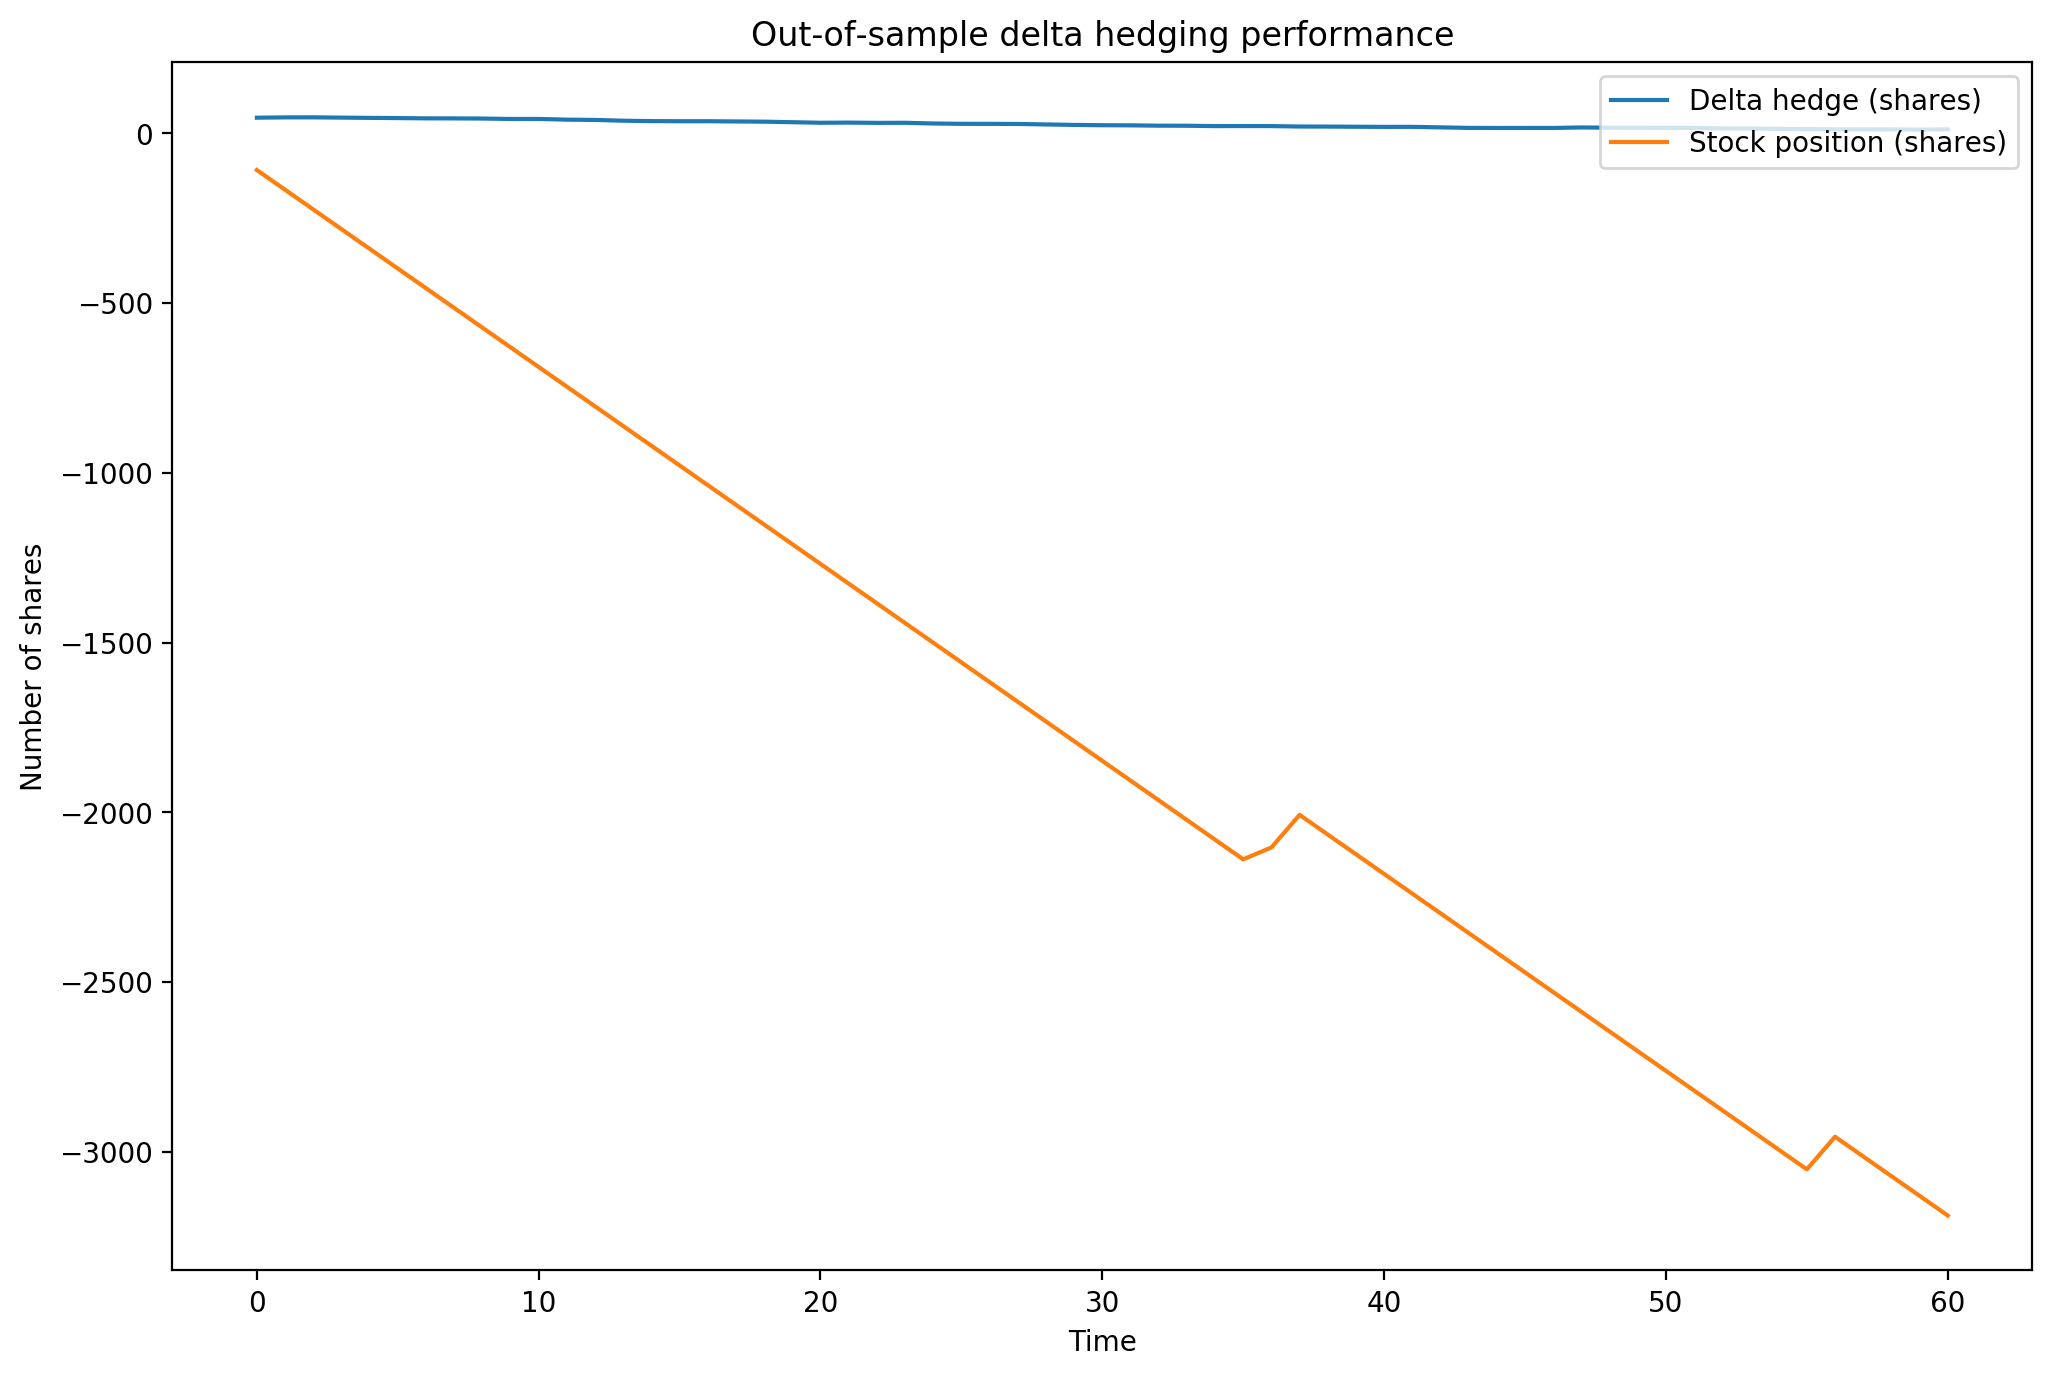

In [173]:
delta_hedge[run_to_plot].loc[:60].plot(label="Delta hedge (shares)")
stock_holdings[run_to_plot].loc[:60].plot(label="Stock position (shares)")

'''
for c in stock_holdings.columns:
    stock_holdings[c].plot(label=f"Stock position (run={c})")
'''

plt.xlabel("Time")
plt.ylabel("Number of shares")

plt.title("Out-of-sample delta hedging performance")

plt.legend(loc='upper right')

In [ ]:
stock_holdings.abs().max(axis='index').min()

In [ ]:
run_to_plot = np.argmax(stock_holdings.max(axis='index'))
run_to_plot

In [ ]:
delta_hedge

In [ ]:
for i in range(10):
    stock_prices[stock_prices.columns[i]].plot(label=f"Stock prices (run = {stock_prices.columns[i]})")
    
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Stock price series")

plt.legend(loc='upper right')

plt.show()